# <b>UMD Info Challenge 2022</b>
## Predicting Removed Loan - Paycheck Protection Program

### <b>U.S. Small Business Administration</b>
Paycheck Protection Program (PPP), a Small Business Administration (SBA)-
backed loan, helps businesses keep employed during the COVID-19. The SBA
has periodically released data on the more than 11.5 million approved
applications, but it also has removed applications that had been previously
present in the dataset for hidden reason. This project focused on loans to
businesses in Georgia with 550k non-removed and 22k removed loans from
the PPP database. The project goals were:
1. Find out characteristics of the removed loans.
2. Compare characteristics of removed and non-removed loans.
3. Build a predictive model with the characteristics we found to predict whether a loan would be removed from the dataset.

<b>Import libraries</b>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import matplotlib as mpl
import matplotlib.ticker as mtick

<b>Add label & Merge dataset</b> <br>
There are two provided dataset, dataset with non-removed loans and dataset with removed loans.

In [3]:
# load non-removed data
df_nremove = pd.read_csv('ppp_applicants_ga_full.csv', index_col = 'loan_number')
# load removed data
df_remove = pd.read_excel('ppp-removed-ga.xlsx', index_col = 'loan_number')

# label data source and combine two dataframes 
df_nremove['mark'] = 'nr'
df_remove['mark'] = 'r'
df = pd.concat([df_nremove, df_remove])

# df['name'].isna().sum()
# df['name'].value_counts()
# df.dtypes
# plt.rcParams['figure.facecolor'] = '#f0f7ff'
# print(graphviz.__version__)

C:\Users\Josh\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### <b>Data Cleaning and Processing</b>
#### Data manipulation
1. format a 5-digit postal code
2. extract the first two digits from the NAICS code to simplify categorization
3. classify multifarious business types into four major classes
4. introduce latitude and longitude to replace zip code of both borrower and lender to reflect more accurate geologic information

In [4]:
# drop unnecessary columns
df = df.drop(columns=['name','state','address','city','lender','congressional_district','term','sba_guaranty_percentage','servicing_lender_address','servicing_lender_city','originating_lender_city','originating_lender_state','forgiveness_date','project_city','project_county_name','project_state','project_zip'])

# rename and extract first 5 digits of zip code
df.rename(columns={'zip': 'borrower_zip'}, inplace = True)
df['borrower_zip'] = df['borrower_zip'].astype(str).str.strip().str.zfill(5).str.extract(r'(\d{5})')
df['servicing_lender_zip'] = df['servicing_lender_zip'].astype(str).str.strip().str.zfill(5).str.extract(r'(\d{5})')

# Simplify NAICS code to 2 digits and replaced NA with '81'
df['naics_code'].fillna('81', inplace = True)
df['naics_code']=df['naics_code'].astype(str).str[:2]

# year month format
df['yearmonth'] = pd.to_datetime(df['date_approved']).dt.to_period('M')

# amount is whole number or decimal flag
df['if_decimal_equal_zero'] = df['initial_approval_amount'].astype(str).str.split('.').str[1].astype(int).map(lambda x: 1 if x == 0 else 0)

# amount difference
df['amount_diff'] = df["amount"] - df["initial_approval_amount"]

# business_type column classification
df['business_type'] = df['business_type'].fillna(0).astype(str)
m1 = df['business_type'].str.contains('Profit')
m2 = df['business_type'].str.contains('Independent|Sole|Single|Individuals|spouses')
m3 = df['business_type'].str.contains('Cooperative|Corporation|ESOP|Liability|Trust|Partnership|Professional|Joint Venture')
df['business_type_classification'] = np.select([m1,m2,m3], ['Non_Profit','Small_Company','Corporation'], default='Others')

# Replace NA with 0
df['forgiveness_amount'] = df['forgiveness_amount'].replace(np.nan, 0)

<b>Convert ZIP code to a latitude longitude pair</b>

In [5]:
# load geographic system dataset. 
df_zip_geo = pd.read_csv('uszips.csv', dtype={'zip': str})
df_zip_geo = df_zip_geo.drop(columns=['city','state_id','state_name','zcta','parent_zcta','population','density','county_fips','county_name','county_weights','county_names_all','county_fips_all','imprecise','military','timezone'
])

# add missing zip code
df_zip = pd.DataFrame({'zip': ['45263','31708','30459','31718','84133','35893','74172','01144','70170'], 
                       'lat': [39.1668,31.5911,32.4486,30.9019,40.7695,34.734,36.1544,42.1032,29.9587], 
                       'lng': [-84.5382,-84.1324,-81.7833,-84.57,-111.8647,-86.5229,-95.9905,-72.5916,-90.0695]})
df_zip_geo = df_zip_geo.append(df_zip, ignore_index = True)

# connect zip code with corresponding latitude and longtitude.
df = pd.merge(df, df_zip_geo, how='left', left_on='borrower_zip', right_on='zip').rename(columns={'lat': 'borrower_lat', 'lng': 'borrower_lng'})
df = pd.merge(df, df_zip_geo, how='left', left_on='servicing_lender_zip', right_on='zip').rename(columns={'lat': 'servicing_lender_lat', 'lng': 'servicing_lender_lng'})

# Remove NA
df = df[df['borrower_lat'].notna()]
df = df[df['borrower_lng'].notna()]

### <b>Exploratory Data Analysis</b>
#### Data visualization
Identified 16 variables that has different characteristics between non-removed and removed loans

<b>Top 10 Servicing Lender Location ID</b>

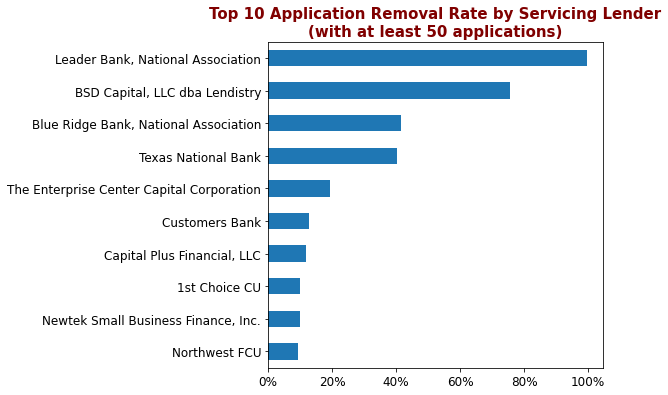

In [6]:
df['servicing_lender_location_id']=df['servicing_lender_location_id'].astype(np.int64).astype(str)
filter_cases = df.groupby('servicing_lender_location_id').filter(lambda x: len(x) > 50)
after = filter_cases.groupby(['servicing_lender_location_id','servicing_lender_name', 'mark']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index(drop=False)\
.sort_values(['mark',0], ascending = (False, False)).rename(columns={0:'proportion'}).head(10)

g = after[after['mark'] == 'r'][after['proportion'] >= 1].sort_values('proportion').plot.barh(x='servicing_lender_name', figsize=(6, 6))
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
g.set_ylabel(None)
g.set_title('Top 10 Application Removal Rate by Servicing Lender\n(with at least 50 applications)', fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
g.get_legend().remove()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show(g)

<b>Top 10 Removed Borrower ZIP codes</b>

Text(0, 0.5, 'ZIP code')

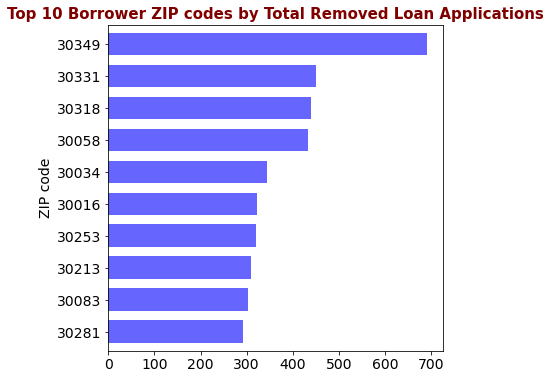

In [7]:
plt.title('Top 10 Borrower ZIP codes by Total Removed Loan Applications',fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

g = df[df['mark'] == 'r'].groupby(['borrower_zip']).size().sort_values(ascending = False).head(10).sort_values().plot.barh(x='borrower_zip', figsize=(6, 6),color='blue',alpha=0.6, width=0.7)
g.set_ylabel('ZIP code', fontsize = 14)

<b>Top 10 Removal Rate by NAICS codes</b>

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

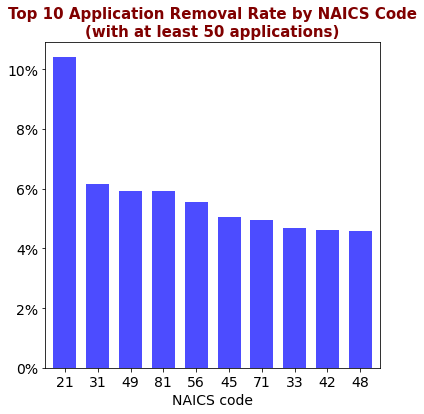

In [8]:
filter_cases = df.groupby('naics_code').filter(lambda x: len(x) > 1)
after = filter_cases.groupby(['naics_code', 'mark']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index(drop=False)\
.sort_values(['mark',0], ascending = (False, False)).rename(columns={0:'proportion'}).head(10)

g = after.plot.bar(x='naics_code',figsize=(6, 6),color='blue',alpha=0.7, width=0.7)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
g.set_title('Top 10 Application Removal Rate by NAICS Code\n(with at least 50 applications)', fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
g.get_legend().remove()
g.tick_params(axis='x', labelrotation=0)
g.set_xlabel('NAICS code', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

<b>Average approval amount - Line Chart</b>

C:\Users\Josh\AppData\Local\Temp/ipykernel_9544/1811059876.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(g.yearmonth,rotation=45, ha='center')


[Text(0, 0, '2020-04'),
 Text(1, 0, '2020-05'),
 Text(2, 0, '2020-06'),
 Text(3, 0, '2020-07'),
 Text(4, 0, '2020-08'),
 Text(5, 0, '2021-01'),
 Text(6, 0, '2021-02'),
 Text(7, 0, '2021-03'),
 Text(8, 0, '2021-04'),
 Text(9, 0, '2021-05'),
 Text(10, 0, '2021-06')]

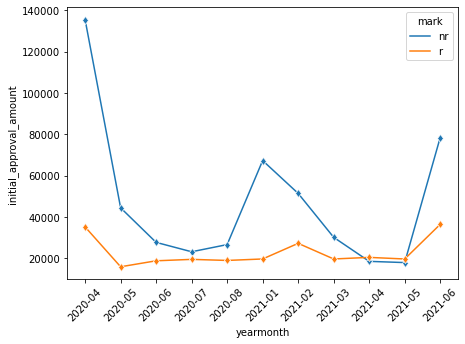

In [9]:
g = df[['mark','initial_approval_amount','yearmonth']]
g = g.groupby(['yearmonth','mark'])['initial_approval_amount'].mean().reset_index()
g.yearmonth = g.yearmonth.astype(str)
g = g.sort_values(by=['mark','yearmonth'])
fig, ax = plt.subplots(figsize=(7,5))
s = sns.lineplot(x='yearmonth', y='initial_approval_amount', data=g, hue='mark', marker='d')
s.set_xticklabels(g.yearmonth,rotation=45, ha='center')

<b>Application Counts by Loan Amount Figures - Line chart</b>

C:\Users\Josh\AppData\Local\Temp/ipykernel_9544/2312733356.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(g.yearmonth,rotation=45, ha='center')


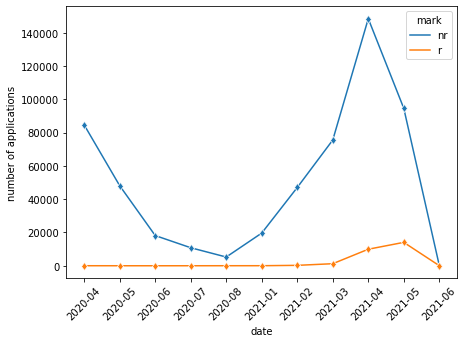

In [10]:
g = df[['mark','yearmonth','if_decimal_equal_zero']]
g = g.groupby(['yearmonth','mark'])['if_decimal_equal_zero'].count().reset_index()

g.yearmonth = g.yearmonth.astype(str)
g = g.sort_values(by=['mark','yearmonth'])
fig, ax = plt.subplots(figsize=(7,5))
s = sns.lineplot(x='yearmonth', y='if_decimal_equal_zero', data=g, hue='mark',marker='d')
s.set_xticklabels(g.yearmonth,rotation=45, ha='center')
s.set(xlabel='date', ylabel='number of applications')
plt.show()

<b>Removal Rate by Loan Amount Figures - Stacked bar</b>

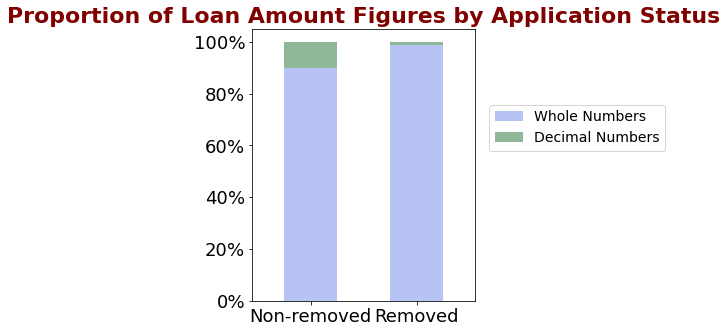

In [12]:
g = df.groupby(['mark','if_decimal_equal_zero']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index(drop=False).rename(columns={0:'proportion'})
x = ['nr', 'r']
y1 = g[g['if_decimal_equal_zero'] == 0]['proportion']
y2 = g[g['if_decimal_equal_zero'] == 1]['proportion']
plt.bar(x, y2, color='#B7C3F3', width=0.5)
plt.bar(x, y1, bottom=y2, color='#8EB897', width=0.5)
plt.rcParams['figure.figsize']=(4,5)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.xticks([0, 1], ['Non-removed', 'Removed'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Proportion of Loan Amount Figures by Application Status', fontdict={'fontsize':22, 'color':'maroon', 'weight':'bold'})
plt.legend(labels=['Whole Numbers', 'Decimal Numbers'], loc='lower left', bbox_to_anchor=(1, 0.5), borderaxespad=1, fontsize=14)
plt.margins(x=0.2, tight=True)

<b>Removal Rate by Loan Amounts</b>

(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

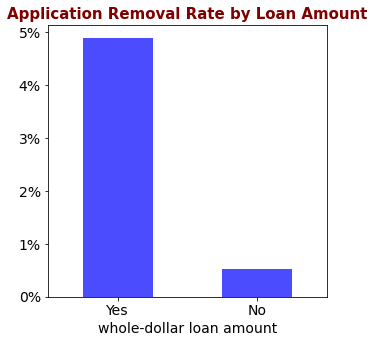

In [14]:
after = filter_cases.groupby(['if_decimal_equal_zero', 'mark']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index(drop=False)\
.sort_values(['mark',0], ascending = (False, False)).rename(columns={0:'proportion'}).head(2)

g = after.plot.bar(x='if_decimal_equal_zero',figsize=(5, 5),color='blue',alpha=0.7, width=0.5)
xlabels = [x for x in g.get_xticks()]
xlabels = ('Yes', 'No')
g.set_xticklabels(xlabels)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

g.set_title('Application Removal Rate by Loan Amount', fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
g.get_legend().remove()
g.tick_params(axis='x', labelrotation=0)
g.set_xlabel('whole-dollar loan amount', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

<b>Loan Status - Stacked chart</b>

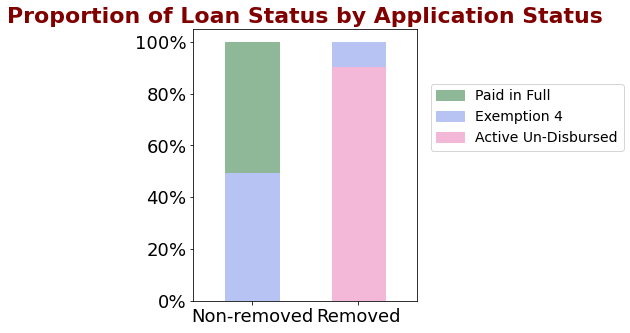

In [15]:
# sns.set_style('darkgrid')
g = df.groupby(['mark','loan_status']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index(drop=False).rename(columns={0:'proportion'})
x = ['nr', 'r']
g = g.append({'mark':'r', 'loan_status':'Paid in Full', 'proportion':0}, ignore_index=True)
y1 = np.array(g[g['loan_status'] == 'Active Un-Disbursed']['proportion'])
y2 = np.array(g[g['loan_status'] == 'Exemption 4']['proportion'])
y3 = np.array(g[g['loan_status'] == 'Paid in Full']['proportion'])

plt.bar(x, np.add(np.add(y3, y2), y1), color='#8EB897', edgecolor='#8EB897', width=0.5)
plt.bar(x, np.add(y2, y1), color='#B7C3F3', edgecolor='#B7C3F3', width=0.5) 
plt.bar(x, y1, color='#f3b7d7', edgecolor='#f3b7d7', width=0.5) 
plt.rcParams['figure.facecolor'] = '#f0f7ff'
plt.rcParams['figure.figsize']=(4,5)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.xticks([0, 1], ['Non-removed', 'Removed'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Proportion of Loan Status by Application Status', fontdict={'fontsize':22, 'color':'maroon', 'weight':'bold'})
plt.legend(labels=['Paid in Full','Exemption 4','Active Un-Disbursed'], loc='lower left', bbox_to_anchor=(1, 0.5), borderaxespad=1, fontsize=14)
plt.margins(x=0.2, tight=True)
plt.show()

<b>Loan Status</b>

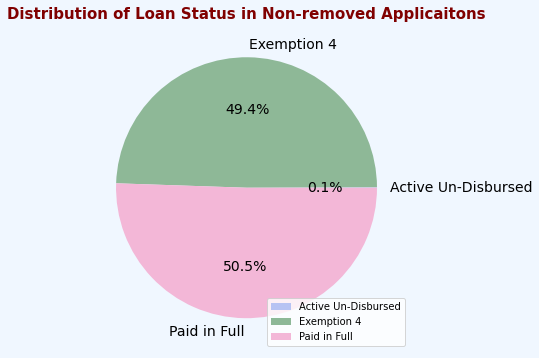

In [16]:
fig = plt.figure(figsize=(6, 6))
l = df[df['mark'] == 'nr']['loan_status'].unique()
g = df[df['mark'] == 'nr'].groupby(['loan_status']).size().transform(lambda x: 100 * x / sum(x)).plot.pie(autopct='%1.1f%%', startangle=0, wedgeprops = {'linewidth': 0, 'edgecolor': 'white'}, colors=['#B7C3F3','#8EB897','#f3b7d7'], textprops={'fontsize': 14})
g.set(ylabel=None)
plt.title('Distribution of Loan Status in Non-removed Applicaitons',fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
plt.legend(['Active Un-Disbursed', 'Exemption 4', 'Paid in Full'], loc='lower right')
# plt.show(g)

<b>Monthly Removed Application Counts - Line chart</b> 

C:\Users\Josh\AppData\Local\Temp/ipykernel_9544/3254875577.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(g.yearmonth,rotation=45, ha='right')


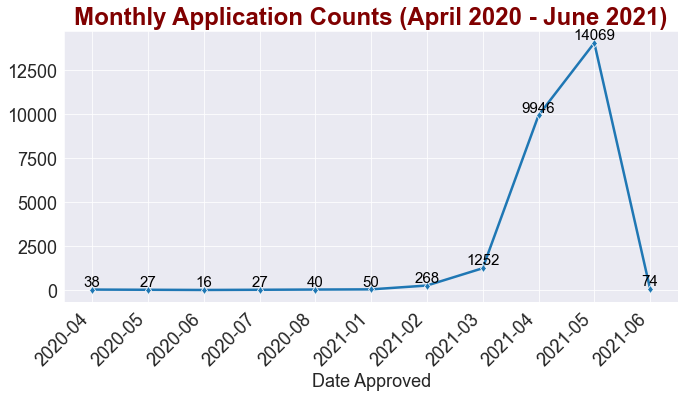

In [17]:
sns.set_style('darkgrid')
g = df[['mark','initial_approval_amount','yearmonth']]
g = g[g['mark'] == 'r'].groupby(['yearmonth'])['initial_approval_amount'].size().reset_index()

g.yearmonth = g.yearmonth.astype(str)
g = g.sort_values(by=['yearmonth'])
fig, ax = plt.subplots(figsize=(11,5))
s = sns.lineplot(x='yearmonth', y='initial_approval_amount', data=g, marker='d',linewidth = 2.5, palette = 'b')
s.set_xticklabels(g.yearmonth,rotation=45, ha='right')
s.axes.set_title('Monthly Application Counts (April 2020 - June 2021)',fontdict={'fontsize':24, 'color':'maroon', 'weight':'bold'})
s.set_xlabel('Date Approved',fontsize=18)
s.set_ylabel(None)
s.tick_params(labelsize=18)

for x,y in g[['yearmonth','initial_approval_amount']].values:
    ax.text(x,y+200,f'{y:.0f}',color='black', fontsize='15', ha='center')

<b>Monthly removal rate</b>

C:\Users\Josh\AppData\Local\Temp/ipykernel_9544/3037735455.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(g.yearmonth,rotation=45, ha='right')


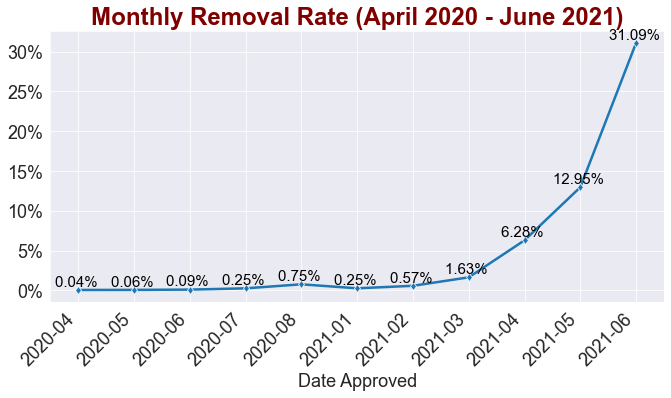

In [18]:
sns.set_style('darkgrid')
g = df[['mark','initial_approval_amount','yearmonth']]
g = g.groupby(['yearmonth', 'mark']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index(drop=False).sort_values(['mark','yearmonth'], ascending = (False, True)).rename(columns={0:'proportion'}).head(11)

g.yearmonth = g.yearmonth.astype(str)
# g = g.sort_values(by=['yearmonth'])
fig, ax = plt.subplots(figsize=(11,5))
s = sns.lineplot(x='yearmonth', y='proportion', data=g, marker='d',linewidth = 2.5, palette = 'b')
s.set_xticklabels(g.yearmonth,rotation=45, ha='right')
s.axes.set_title('Monthly Removal Rate (April 2020 - June 2021)',fontdict={'fontsize':24, 'color':'maroon', 'weight':'bold'})
s.set_xlabel('Date Approved',fontsize=18)
s.set_ylabel(None)
s.tick_params(labelsize=18)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# plt.show(g)
plt.rcParams['figure.facecolor'] = '#f0f7ff'
for x,y in g[['yearmonth','proportion']].values:
    ax.text(x,y+0.5,f'{y:.2f}% ',color='black', fontsize='15', ha='center')

<b>Monthly Removed Application Counts - Bar chart</b> 

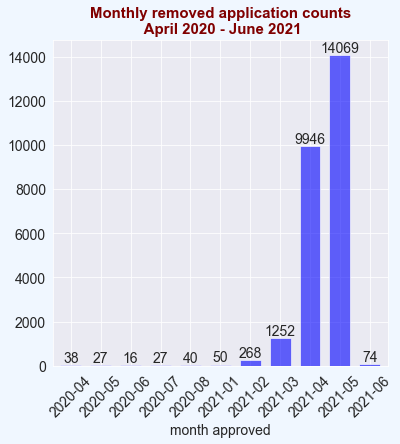

In [19]:
g = df[df['mark'] == 'r'].groupby(['yearmonth']).size().plot.bar(figsize=(6, 6),color='blue',alpha=0.6, width=0.7)
g.tick_params(axis='x', labelrotation=45)
g.set_xlabel('month approved', fontsize = 14)
c = df[df['mark'] == 'r'].groupby(['yearmonth']).size()
for index, value in enumerate(c):
    plt.text(index, value, str(value),ha = 'center', va = 'bottom', fontsize=14)
plt.title('Monthly removed application counts\n April 2020 - June 2021',fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(g)

<b>Age Group - Stacked chart</b>

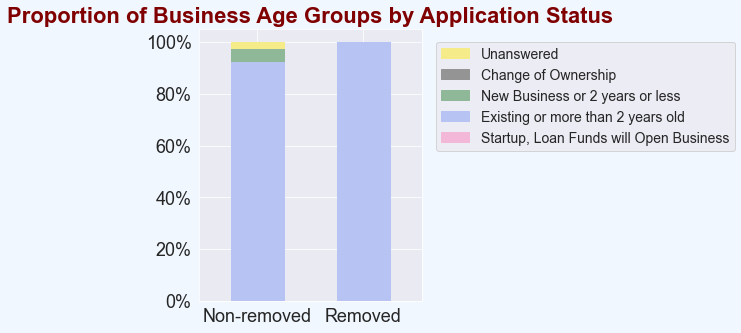

In [20]:
g = df.groupby(['mark','business_age_description']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index(drop=False).rename(columns={0:'proportion'})
x = ['nr', 'r']
y1 = np.array(g[g['business_age_description'] == 'Change of Ownership']['proportion'])
y2 = np.array(g[g['business_age_description'] == 'Existing or more than 2 years old']['proportion'])
y3 = np.array(g[g['business_age_description'] == 'New Business or 2 years or less']['proportion'])
y4 = np.array(g[g['business_age_description'] == 'Startup, Loan Funds will Open Business']['proportion'])
y5 = np.array(g[g['business_age_description'] == 'Unanswered']['proportion'])

plt.bar(x, np.add(np.add(np.add(np.add(y5, y4), y3),y2),y1), color='#f5ec89', edgecolor='#f5ec89', width=0.5)
plt.bar(x, np.add(np.add(np.add(y4, y3), y2),y1), color='#949494', edgecolor='#949494', width=0.5)
plt.bar(x, np.add(np.add(y3, y2), y1), color='#8EB897', edgecolor='#8EB897', width=0.5)
plt.bar(x, np.add(y2, y1), color='#B7C3F3', edgecolor='#B7C3F3', width=0.5) 
plt.bar(x, y1, color='#f3b7d7', edgecolor='#f3b7d7', width=0.5) 
plt.rcParams['figure.facecolor'] = '#f0f7ff'
plt.rcParams['figure.figsize']=(9,5)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.xticks([0, 1], ['Non-removed', 'Removed'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Proportion of Business Age Groups by Application Status', fontdict={'fontsize':22, 'color':'maroon', 'weight':'bold'})
plt.legend(labels=['Unanswered','Change of Ownership','New Business or 2 years or less','Existing or more than 2 years old','Startup, Loan Funds will Open Business'], loc='lower left', bbox_to_anchor=(1, 0.5), borderaxespad=1, fontsize=14)
plt.margins(x=0.2, tight=True)

<b>Age Gruop - Non Removed - Pie chart</b>

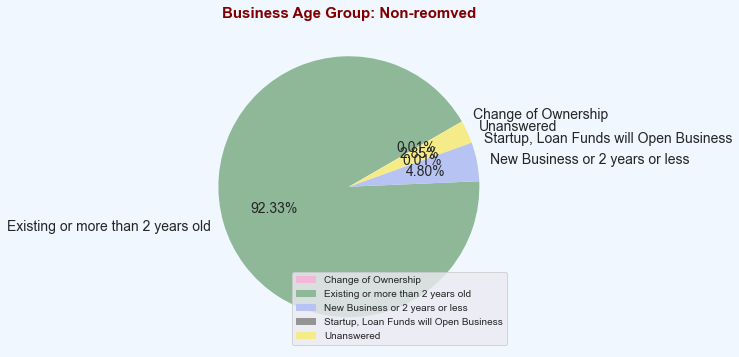

In [21]:
fig = plt.figure(figsize=(6, 6))
l = df[df['mark'] == 'nr']['business_age_description'].unique()
g = df[df['mark'] == 'nr'].groupby('business_age_description').size().transform(lambda x: 100 * x / sum(x)).plot.pie(autopct='%1.2f%%', startangle=30,wedgeprops = {'linewidth': 0, 'edgecolor': 'white'}, colors=['#f3b7d7','#8EB897', '#B7C3F3', '#949494', '#f5ec89'], textprops={'fontsize': 14})
g.set(ylabel=None)
plt.title('Business Age Group: Non-reomved',fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
plt.legend(['Change of Ownership','Existing or more than 2 years old', 
       'New Business or 2 years or less',
       'Startup, Loan Funds will Open Business', 'Unanswered'], loc='lower right')

<b>Age Gruop - Removed - Pie chart</b>

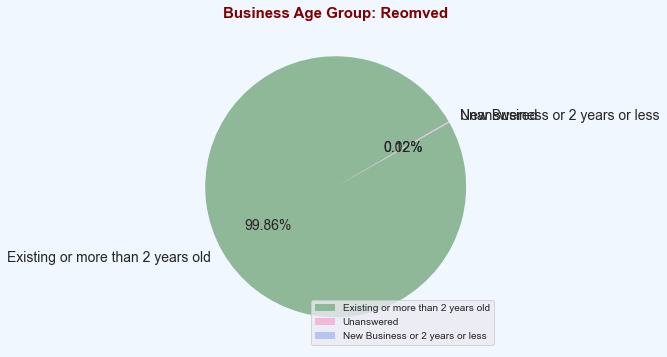

In [22]:
fig = plt.figure(figsize=(6, 6))
l = df[df['mark'] == 'r']['business_age_description'].unique()
g = df[df['mark'] == 'r'].groupby('business_age_description').size().transform(lambda x: 100 * x / sum(x)).plot.pie(autopct='%1.2f%%', startangle=30,wedgeprops = {'linewidth': 0, 'edgecolor': 'white'}, colors=['#8EB897','#f3b7d7', '#B7C3F3'], textprops={'fontsize': 14})
g.set(ylabel=None)
plt.title('Business Age Group: Reomved',fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
plt.legend(['Existing or more than 2 years old', 'Unanswered',
       'New Business or 2 years or less'], loc='lower right')

<b>Business Type</b>

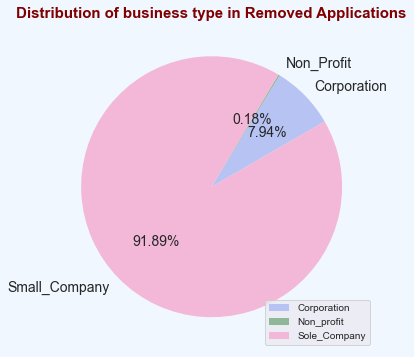

In [23]:
fig = plt.figure(figsize=(6, 6))
l = df[df['mark'] == 'r']['business_type_classification'].unique()
g = df[df['mark'] == 'r'].groupby('business_type_classification').size().transform(lambda x: 100 * x / sum(x)).plot.pie(autopct='%1.2f%%', startangle=30,wedgeprops = {'linewidth': 0, 'edgecolor': 'white'}, colors=['#B7C3F3','#8EB897', '#f3b7d7'], textprops={'fontsize': 14})
g.set(ylabel=None)
plt.title('Distribution of business type in Removed Applications',fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
plt.legend(['Corporation','Non_profit','Sole_Company'], loc='lower right')

<b>Business Type Propotion</b>

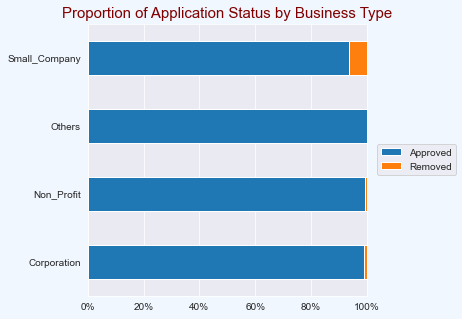

In [24]:
df_after = df.groupby('business_type_classification').filter(lambda x: len(x) > 1)
g = df_after.groupby(['business_type_classification','mark']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).unstack(1).plot.barh(stacked=True, figsize=(5, 5))
g.set_title('Proportion of Application Status by Business Type',fontdict={'fontsize':15, 'color':'maroon'})
g.set(ylabel=None)
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# Put the legend out of the figure
g.legend(labels=['Approved', 'Removed'], loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1)
g.margins(x=0)

<b>Business Type - Pie chart</b>

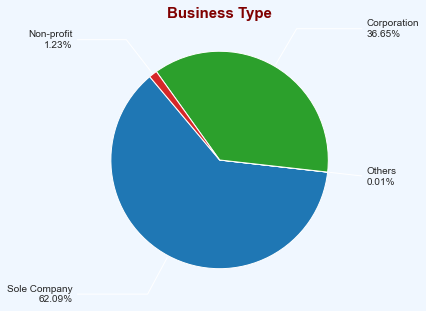

In [25]:
bbox_props=dict(boxstyle='square,pad=0.3',fc ='w',ec='k',lw=0.72)
kw=dict(xycoords='data',textcoords='data',arrowprops=dict(arrowstyle='-'),zorder=0,va='center')

fig1,ax1=plt.subplots(figsize=(5,5))
labels=['Sole Company\n62.09%','Non-profit\n1.23%','Corporation\n36.65%', 'Others\n0.01%']
values=[62.09,1.23,36.65,0.01]
# Add code
annotate_dict = {k:v for k,v in zip(labels, values)}
val = [[x,y] for x,y in zip(sorted(values, reverse=True),sorted(values))]
values1 = sum(val, [])

new_labels = []
for v in values1[:len(values)]:
    for key, value in annotate_dict.items():
        if v == value:
            new_labels.append(key)
            
wedges,texts=ax1.pie(values1[:len(values)],explode=[0,0,0,0],labeldistance=1.2,startangle=130)
for i,p in enumerate(wedges):
    ang=(p.theta2-p.theta1)/2. +p.theta1
    y=np.sin(np.deg2rad(ang))
    x=np.cos(np.deg2rad(ang))
    horizontalalignment={-1:'right',1:'left'}[int(np.sign(x))]
    connectionstyle='angle,angleA=0,angleB={}'.format(ang)
    kw['arrowprops'].update({'connectionstyle':connectionstyle})
    ax1.annotate(new_labels[i],xy=(x, y),xytext=(1.35*np.sign(x),1.4*y),
                horizontalalignment=horizontalalignment,**kw)
plt.title('Business Type',fontdict={'fontsize':15, 'color':'maroon', 'weight':'bold'})
plt.show()

### <b>Predictive Modeling</b>
<b>Prepare training and testing data</b>

In [7]:
x = df[['amount', 'borrower_lat', 'borrower_lng', 'naics_code', 'business_type_classification', 'jobs_retained', 'loan_status', 'servicing_lender_lat', 'servicing_lender_lng', 'hubzone_indicator',
       'business_age_description', 'lmi_indicator', 'forgiveness_amount', 'amount_diff', 'if_decimal_equal_zero', 'yearmonth']]
# convert labels into binary values
y = df['mark'].map(lambda x: 1 if x == 'r' else 0)
# Convert all categorical variables to dummies
x['yearmonth'] = x['yearmonth'].astype('category')
x = pd.get_dummies(x)

C:\Users\Josh\AppData\Local\Temp/ipykernel_2392/4263972548.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['yearmonth'] = x['yearmonth'].astype('category')


#### <b>XGBoost</b>

In [8]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 20742)

# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, recall_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Loading library for plotting xgboost
from xgboost import plot_tree

# pip install --upgrade graphviz==0.19
import graphviz as gr

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [9]:
# put the best hyperparameters
clf=xgb.XGBClassifier(objective='binary:logistic',use_label_encoder =False)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
auc =roc_auc_score(y_test, y_pred)
print ('Accuracy:', accuracy)
print ('AUC:', auc)

[13:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9951383802674756
AUC: 0.951791663399128


Text(0.5, 257.44, 'Predicted label')

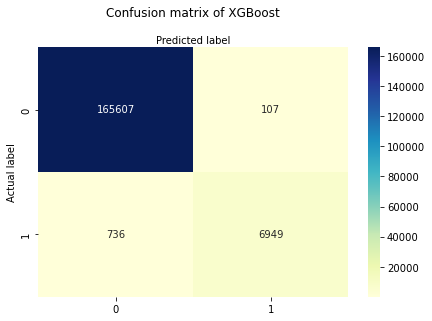

In [10]:
# Make confusion matrix of XGBoost
from sklearn.metrics import confusion_matrix
cfm_xgb = confusion_matrix(y_test, y_pred)

# Plot confusion matrix of XGBoost
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cfm_xgb), annot=True, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix of XGBoost', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

No handles with labels found to put in legend.


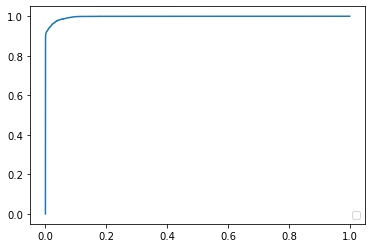

In [11]:
# Plot ROC of XGBoost
xgb_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  xgb_pred_proba)
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

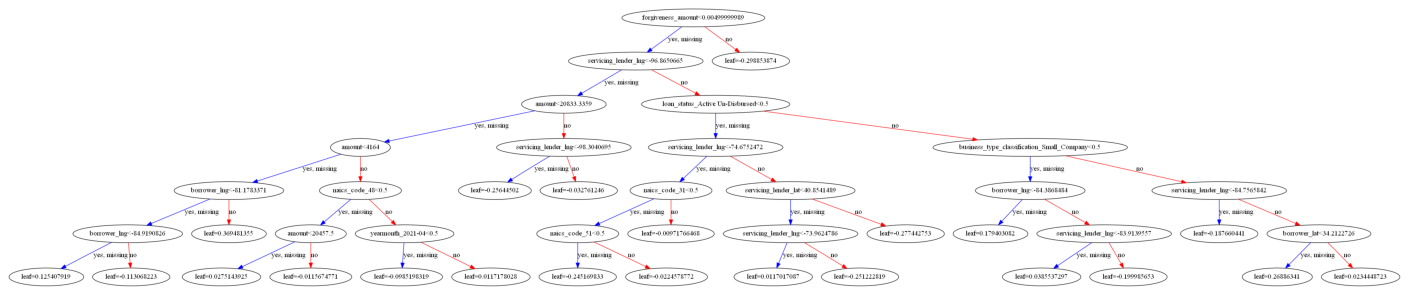

In [30]:
# Plot the XGBoost tree
xgb_tree__plot = plot_tree(clf, decision_tree = 'classifier', num_trees=21)
fig = xgb_tree__plot.figure
fig.set_size_inches(25, 25)

#### Variables' importance ranking by XGBoost
We can see from the graph that XGBoost recognize top five most important variables are amount, borrower's latitude and longtitude, and lender's latitude and longtitude.

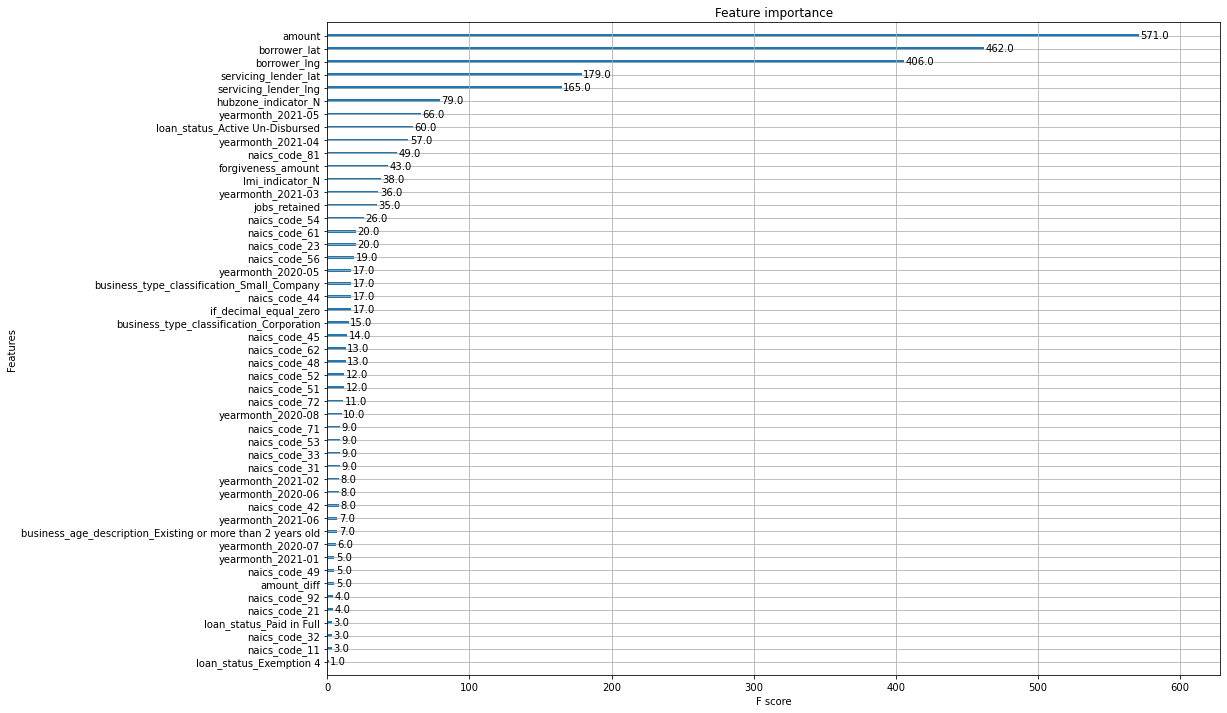

In [61]:
# Plot the importance ranking of XGBoost
vip_plot = xgb.plot_importance(clf)
fig = vip_plot.figure
fig.set_size_inches(16, 12)

#### <b>Logistic Regression</b>

In [31]:
#Logistic Regression
from sklearn import linear_model

model=linear_model.LogisticRegression()
model_fit = model.fit(x_train,y_train)
y_pred = model.predict(x_test)

C:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# Make confusion matrix of LR
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
cfm_lr = confusion_matrix(y_test, y_pred)

# Output performance of LR model
accuracy = accuracy_score(y_test, y_pred)
auc =roc_auc_score(y_test, y_pred)
print(accuracy)
print(auc)

0.9774969867184932
0.7754759002719793


Text(0.5, 257.44, 'Predicted label')

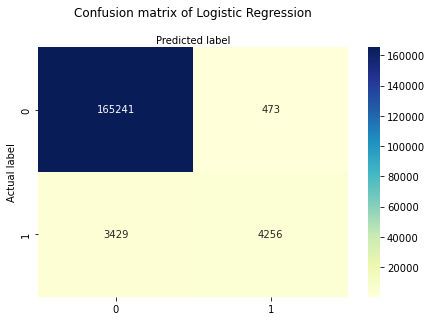

In [33]:
# plotting confusion matrix of LR
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfm_lr), annot=True, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix of Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

No handles with labels found to put in legend.


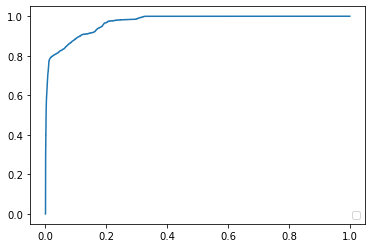

In [34]:
# Plot ROC of LR
lr_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  lr_pred_proba)
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()